# 1 - DEFINE THE PROBLEM

The goal of this project is to build a machine learning model that predicts whether a passenger survived or not during the Titanic shipwreck, based on features such as age, gender, class, fare, and other available attributes.

# 2 - IMPORT REQUIRED LIBRARIES

Import other necessary libraries/packages based on the problem

## 2.1 - Base Libraries

In [30]:
import os
import re
import sys
import tarfile
import email
import email.policy

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import urllib.request
import seaborn as sns

## 2.2 - ML/DL Libraries

In [2]:
from collections import Counter
from html import unescape
from scipy.ndimage import shift
from scipy.sparse import csr_matrix

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# 3 - LOAD THE DATA
Load the dataset from online source.

In [3]:
TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

In [ ]:
#Function to fetch the titanic dataset from the web

#check if a folder exists, if not create it and download the data

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

In [5]:
fetch_titanic_data()    

In [ ]:
#This piece of code defines a function that loads a Titanic dataset CSV file into a pandas DataFrame. 

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [ ]:
#This loads the training dataset (used to train your model) from the file train.csv.
train_data = load_titanic_data("train.csv")

#This loads the test dataset (used to test/predict with your trained model) from the file test.csv.
test_data = load_titanic_data("test.csv")

 4 - EDA (Exploratory Data Analysis) of the DATA


In [ ]:

#Returns the first 5 rows of the training dataset.
#It helps you preview the structure and contents of the train_data DataFrame.

print(train_data.head())
print(test_data.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [ ]:
#Sets the PassengerId column as the index of the DataFrame.
#This means that instead of using default row numbers (0, 1, 2...), the DataFrame will now use PassengerId to label each row.
# this makes the data more readable and allows for easier access to specific rows based on PassengerId.

train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

 4.1 - Basic Overview

In [ ]:

#Display summary information about each DataFrame (train_data and test_data).

print(train_data.info())
print(test_data.info())
print()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null

In [ ]:
#This line calculates the median age of female passengers in the Titanic training dataset.
train_data[train_data["Sex"]=="female"]["Age"].median()

27.0

In [ ]:
#This code prints summary statistics for all columns (both numeric and categorical) in the train_data and test_data DataFrames.
print(train_data.describe(include='all'))
print(test_data.describe(include='all'))
print()


          Survived      Pclass                     Name   Sex         Age  \
count   891.000000  891.000000                      891   891  714.000000   
unique         NaN         NaN                      891     2         NaN   
top            NaN         NaN  Braund, Mr. Owen Harris  male         NaN   
freq           NaN         NaN                        1   577         NaN   
mean      0.383838    2.308642                      NaN   NaN   29.699113   
std       0.486592    0.836071                      NaN   NaN   14.526507   
min       0.000000    1.000000                      NaN   NaN    0.416700   
25%       0.000000    2.000000                      NaN   NaN   20.125000   
50%       0.000000    3.000000                      NaN   NaN   28.000000   
75%       1.000000    3.000000                      NaN   NaN   38.000000   
max       1.000000    3.000000                      NaN   NaN   80.000000   

             SibSp       Parch  Ticket        Fare    Cabin Embarked  
coun

In [57]:
#This code prints the count of each unique value in the "Survived" column of the train_data

print(train_data["Survived"].value_counts())

Survived
0    549
1    342
Name: count, dtype: int64


In [60]:
#This line prints the count of each unique value in the "Pclass" column of the train_data DataFrame.
print(train_data["Pclass"].value_counts())

print()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64



In [ ]:
#This code prints the count of each unique value in the "Sex" column for both the training (train_data) and test (test_data) datasets.

print(train_data["Sex"].value_counts())
print(test_data["Sex"].value_counts())
print()

Sex
male      577
female    314
Name: count, dtype: int64
Sex
male      266
female    152
Name: count, dtype: int64



In [20]:
print(train_data["Embarked"].value_counts())
print(test_data["Embarked"].value_counts())
print()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64
Embarked
S    270
C    102
Q     46
Name: count, dtype: int64



## 4.2 - Check for Missing Values

In [22]:
train_data.isnull().sum()
test_data.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

## 4.3 - Analyze Data Types

In [26]:
test_data.dtypes
train_data.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [27]:
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [28]:
test_data

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S


# 5 - VISUALIZE THE DATA

## 5.1 - UNIVARIATE ANALYSIS

### Example: Distribution of a numerical variable using seaborn and matplotlib  
Replace 'feature_name' with the column you want to analyze

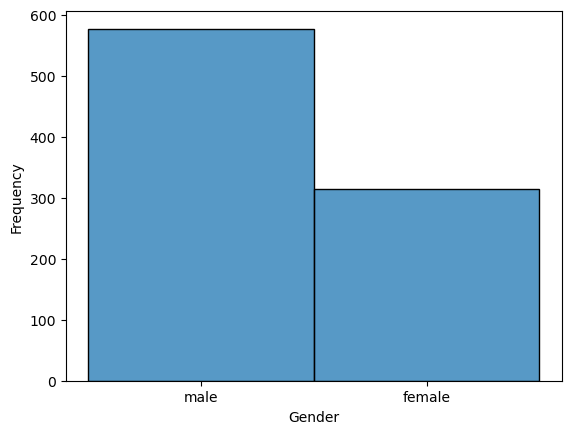

In [34]:
# Seaborn histogram
sns.histplot(train_data['Sex'])
#plt.title("Distribution of feature_name (Seaborn)")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.show()

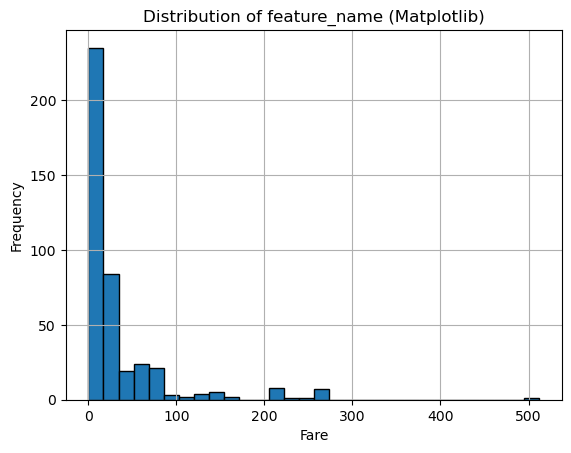

In [36]:
# Matplotlib histogram
plt.hist(test_data['Fare'], bins=30, edgecolor='black')
plt.title("Distribution of feature_name (Matplotlib)")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
#defines a pipeline named num_pipeline for preprocessing numeric data in your dataset.

#So, this pipeline:

#First fills missing numeric values with the median,
#Then scales the numeric data.

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [ ]:
#So, this pipeline:

#First fills missing categorical values with the most frequent category,
#Then converts categories into one-hot encoded features.

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])


In [ ]:
#These lists help separate which columns will undergo numerical transformations (like scaling, imputing median) 
# and which will undergo categorical processing (like imputing most frequent and one-hot encoding).
num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

In [ ]:
#So, when you run this pipeline on your data, it will:

#Impute missing numerical values with median and scale the numerical features.
#Impute missing categorical values with the most frequent value and one-hot encode the categorical features.

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [ ]:
#This code is applying your preprocessing pipeline to the training data features and then printing the transformed data. 
# Here’s what each part does

X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
print(X_train)
#y_train = train_data["Survived"].values
print()

[[-0.56573582  0.43279337 -0.47367361 ...  0.          0.
   1.        ]
 [ 0.6638609   0.43279337 -0.47367361 ...  1.          0.
   0.        ]
 [-0.25833664 -0.4745452  -0.47367361 ...  0.          0.
   1.        ]
 ...
 [-0.10463705  0.43279337  2.00893337 ...  0.          0.
   1.        ]
 [-0.25833664 -0.4745452  -0.47367361 ...  1.          0.
   0.        ]
 [ 0.20276213 -0.4745452  -0.47367361 ...  0.          1.
   0.        ]]



In [45]:
y_train = train_data["Survived"]

In [46]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [47]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

0.8160049937578027
0.04015435437446853


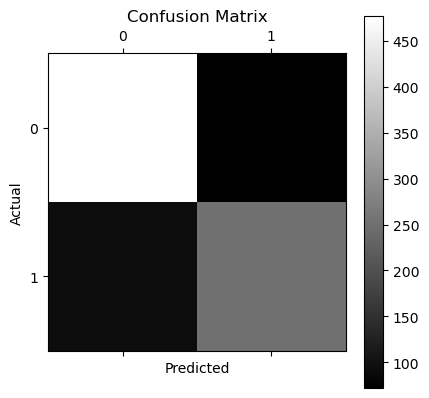

In [50]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
print(forest_scores.mean())
print(forest_scores.std())
forest_y_pred = cross_val_predict(forest_clf, X_train, y_train, cv=10)
conf_mx = confusion_matrix(y_train, forest_y_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

In [51]:
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
print(svm_scores.mean())
print(svm_scores.std())
svm_y_pred = cross_val_predict(svm_clf, X_train, y_train, cv=10)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_train, forest_y_pred))
print("F1 Score:", f1_score(y_train, forest_y_pred))
print("Precision:", precision_score(y_train, forest_y_pred))
print("Recall:", recall_score(y_train, forest_y_pred))
print("ROC AUC Score:", roc_auc_score(y_train, forest_y_pred))
print("SVM Classifier:")

0.8249313358302123
0.030955662267404517
Random Forest Classifier:
Accuracy: 0.8159371492704826
F1 Score: 0.7530120481927711
Precision: 0.7763975155279503
Recall: 0.7309941520467836
ROC AUC Score: 0.7999233055315885
SVM Classifier:


### Example: Correlation heatmap (Seaborn only, but with Matplotlib styling)

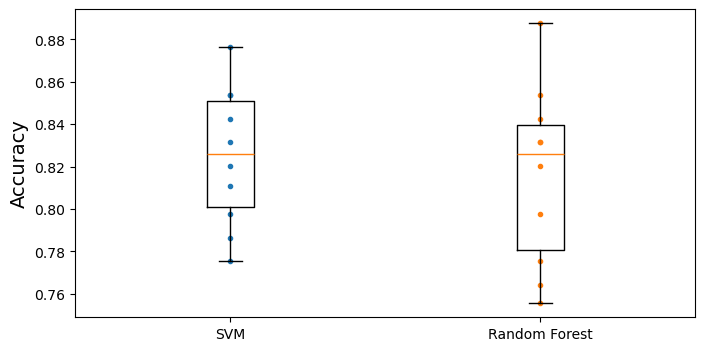

In [52]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], tick_labels=["SVM", "Random Forest"])  # actualizado
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [ ]:
#You’re analyzing survival rates by age groups, which helps understand how survival chances differ by age ranges.
#  This can also help with feature engineering if you want to use age buckets instead of raw age.

train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()
print(train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean())
print()

           Survived
AgeBucket          
0.0        0.576923
15.0       0.362745
30.0       0.423256
45.0       0.404494
60.0       0.240000
75.0       1.000000



In [ ]:
#Groups the data by the number of relatives onboard.
#Calculates the average survival rate (Survived column) for each group.

train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()
print(train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean())
print()



                  Survived
RelativesOnboard          
0                 0.303538
1                 0.552795
2                 0.578431
3                 0.724138
4                 0.200000
5                 0.136364
6                 0.333333
7                 0.000000
10                0.000000



STILL UNDER IMMENSE REVIEW 